In [73]:
import wrds
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.optimize import minimize
from scipy.optimize import basinhopping

In [128]:
def price_to_yield_semi_annual(price, coupon, tau):
    """
    Converts bond price to yield for semi-annual coupon bonds.
    :param price: Bond price
    :param coupon: Annual coupon rate of the bond
    :param tau: Time to maturity in years
    :return: Yield for semi-annual coupon bond
    """
    if tau <= 0 or price <= 0:
        return float('nan')  # Return NaN for non-feasible values
    
    periods = int(tau * 2)  # Number of six-month periods
    coupon_payment = coupon / 2  # Semi-annual coupon payment
    
    # Initial guess for YTM
    ytm = coupon / price
    tolerance = 1e-6
    max_iterations = 1000
    iteration = 0

    while iteration < max_iterations:
        price_calculated = sum([coupon_payment / (1 + ytm / 2) ** (i + 1) for i in range(periods - 1)]) + (100 + coupon_payment) / (1 + ytm / 2) ** periods
        diff = price_calculated - price
        
        if abs(diff) < tolerance:
            break

        ytm -= diff / 10  # Adjust the YTM guess
        if ytm < 0:
            ytm = tolerance  # Prevent negative YTM

        iteration += 1

    if iteration == max_iterations:
        return float('nan')  # Return NaN if no convergence

    return ytm * 100  # Convert to percentage

# Example usage: 
# Assuming you have the row data as before
# yield_result = price_to_yield_semi_annual(row['midprice'], row['coupon'], row['tau'])
# print(yield_result)

def subset_and_filter_data(dataframe, start_minute):
    """
    For each cusip, selects the row that has the time closest to the start time, 
    sorts the result by tau, and drops observations with tau > 10.

    :param dataframe: pandas DataFrame containing the data.
    :param start_minute: Integer representing the starting minute.
    :return: Processed DataFrame.
    """
    end_minute = start_minute + 5

    # Filter the dataframe for the specified time range
    filtered_df = dataframe[(dataframe['minute'] >= start_minute) & (dataframe['minute'] < end_minute)]

    # Group by 'cusip' and select the row with the closest time to start_minute
    closest_rows = filtered_df.groupby('cusip').apply(lambda x: x.loc[(x['minute'] - start_minute).abs().idxmin()])

    # Sort the resulting DataFrame by 'tau'
    sorted_closest_rows = closest_rows.sort_values(by='tau')

    # Drop observations where tau > 10
    final_df = sorted_closest_rows[(sorted_closest_rows['tau'] >= 1) & (sorted_closest_rows['tau'] <= 10)].reset_index(drop=True)
    return_df = final_df[final_df['midprice'] >= 0.6].reset_index(drop=True)
    
    return return_df


def svensson_yield(tau, beta0, beta1, beta2, beta3, lambda1, lambda2):
    """Calculates the yield for a given maturity tau using the Svensson model."""
    term1 = (1 - np.exp(-lambda1 * tau)) / (lambda1 * tau)
    term2 = term1 - np.exp(-lambda1 * tau)
    term3 = ((1 - np.exp(-lambda2 * tau)) / (lambda2 * tau)) - np.exp(-lambda2 * tau)
    return beta0 + beta1 * term1 + beta2 * term2 + beta3 * term3

def calculate_macaulay_duration(coupon_rate, ytm, time_to_expiration, face_value=1):
    """
    Calculates the Macaulay duration of a bond.

    :param coupon_rate: The annual coupon rate of the bond as a decimal
    :param ytm: The yield to maturity of the bond as a decimal
    :param time_to_expiration: The time to expiration of the bond in years
    :param face_value: The face value of the bond (default is 100)
    :return: The Macaulay duration of the bond
    """
    # Calculate the periodic coupon payment
    coupon_payment = coupon_rate * face_value
    
    # Calculate the discount rate
    discount_rate = 1 + ytm
    
    # Calculate the present value of each cash flow
    cash_flows = np.array([coupon_payment if period < time_to_expiration else coupon_payment + face_value
                           for period in range(1, int(time_to_expiration) + 1)])
    
    # Calculate the time-weighted present value of each cash flow
    time_weighted_pv_cash_flows = np.array([cash_flow / discount_rate**period * period
                                            for period, cash_flow in enumerate(cash_flows, start=1)])
    
    # Calculate the total present value of the bond
    total_pv = np.sum(cash_flows / discount_rate**np.arange(1, int(time_to_expiration) + 1))
    
    # Calculate the Macaulay duration
    duration = np.sum(time_weighted_pv_cash_flows) / total_pv
    
    return duration

def theoretical_bond_price(coupon, face_value, maturity, frequency, beta_params):
    """Calculates the theoretical price of a bond using the Svensson model."""
    num_payments = int(np.ceil(maturity * frequency))  # Number of coupon payments, rounded up
    cash_flows = np.array([coupon * face_value / frequency] * (num_payments - 1) + [coupon * face_value / frequency + face_value])
    
    # Time of each cash flow
    times = np.arange(1 / frequency, maturity + 1 / frequency, 1 / frequency)
    
    # Calculate discount factors for each cash flow
    discount_factors = np.array([np.exp(-svensson_yield(time, *beta_params) * time) for time in times])
    
    # Calculate present value of each cash flow
    pv_cash_flows = cash_flows * discount_factors
    
    # Sum the present values to get the bond price
    bond_price = np.sum(pv_cash_flows)
    
    return bond_price


def objective_function(beta_params, bond_data):
    """Objective function to minimize the difference between market and model prices."""
    residuals = 0
    for index, row in bond_data.iterrows():
        market_price = row['midprice']
        duration = row['Duration']
        coupon = row['coupon']
        face_value = 1  # assuming a face value of 100
        maturity = row['tau']
        frequency = 2  # assuming semi-annual coupons
        model_price = theoretical_bond_price(coupon, face_value, maturity, frequency, beta_params)
        residuals += (market_price - model_price)**2 / duration
    return residuals


def plot_prices_vs_maturity(bond_data):
    # Plot both observed and model prices against time to maturity
    plt.scatter(bond_data['tau'], bond_data['ytm'], color='blue', label='Observed Yield')   
    plt.xlabel('Time to Maturity (Years)')
    plt.ylabel('Price')
    plt.title('Yields vs. Time to Maturity')
    plt.legend()
    plt.grid(True)
    plt.show()


In [99]:
wrds_username = 'pshultz'
db = wrds.Connection(wrds_username=wrds_username)

Loading library list...
Done


In [100]:
# List all databases
all_databases = db.list_libraries()

# Filter databases starting with 'govpx'
govpx_databases = [db for db in all_databases if db.startswith('govpx')]

print(govpx_databases)

['govpx', 'govpx_common', 'govpx_ticks1991', 'govpx_ticks1992', 'govpx_ticks1993', 'govpx_ticks1994', 'govpx_ticks1995', 'govpx_ticks1996', 'govpx_ticks1997', 'govpx_ticks1998', 'govpx_ticks1999', 'govpx_ticks2000', 'govpx_ticks2001', 'govpx_ticks2002', 'govpx_ticks2003', 'govpx_ticks2004', 'govpx_ticks2005', 'govpx_ticks2006', 'govpx_ticks2007', 'govpx_ticks2008', 'govpx_ticks2009', 'govpx_ticks2010', 'govpx_ticks2011', 'govpx_ticks2012', 'govpx_ticks2013', 'govpx_ticks2014', 'govpx_ticks2015', 'govpx_ticks2016', 'govpx_ticks2017', 'govpx_ticks2018', 'govpx_ticks2019', 'govpx_ticks2020', 'govpx_ticks2021', 'govpx_ticks2022', 'govpxsamp_all', 'govpxsmp']


In [101]:
database_name = 'govpx_ticks2022'
tables = db.list_tables(library=database_name)
tables

['ticks22']

In [102]:


# Querying the GovPX dataset
# Modify the SQL query according to your specific requirements

govpx_data = db.raw_sql("""
SELECT cusip, coupon, matdate, type, indbid, indask, indbyld, indayld, date, time
FROM govpx_ticks2015.ticks15
WHERE date = '2015-04-22'
""")

# For example, to see the first few rows of the dataset:
print(govpx_data.head())
print("Number of rows in the DataFrame:", govpx_data.shape[0])

       cusip  coupon     matdate   type  indbid  indask  indbyld  indayld  \
0  912796DY2     0.0  2015-04-30  152.0   0.040   0.030    0.041    0.030   
1  912796DY2     0.0  2015-04-30    NaN   0.045   0.035    0.046    0.035   
2  912796DY2     0.0  2015-04-30    NaN     NaN     NaN      NaN      NaN   
3  912796DY2     0.0  2015-04-30    NaN   0.045   0.010    0.046    0.010   
4  912796DY2     0.0  2015-04-30    NaN     NaN     NaN      NaN      NaN   

         date       time  
0  2015-04-22   1922.623  
1  2015-04-22  25639.653  
2  2015-04-22  25650.280  
3  2015-04-22  25826.923  
4  2015-04-22  26334.340  
Number of rows in the DataFrame: 344822


In [103]:
# Disconnect from WRDS
db.close()

In [117]:
# clean daily data
# List of columns to check for NaN values
columns_to_check = ['indbid', 'indbyld', 'indask', 'indayld']

# Drop rows where all specified columns are NaN
govpx_data_cleaned = govpx_data.dropna(subset=columns_to_check, how='all')
print("Number of rows in the cleaned DataFrame:", govpx_data_cleaned.shape[0])

Number of rows in the cleaned DataFrame: 342384


In [118]:
# drop on the run securities
govpx_data_filtered = govpx_data_cleaned[(govpx_data_cleaned['type'] != 152)&(govpx_data_cleaned['type'] != 157)&(govpx_data_cleaned['type'] != 161)&(govpx_data_cleaned['type'] != 155)&(govpx_data_cleaned['type'] != 154)]
print("Number of rows in the cleaned DataFrame:", govpx_data_filtered.shape[0])

Number of rows in the cleaned DataFrame: 342169


In [119]:
# Create a copy of the DataFrame slice to avoid SettingWithCopyWarning
govpx_data_filtered = govpx_data_filtered.copy()

# Now, you can safely make modifications
govpx_data_filtered.loc[:, 'midprice'] = (govpx_data_filtered.loc[:, 'indbid']/100 + govpx_data_filtered.loc[:, 'indask']/100) / 2
govpx_data_filtered.loc[:, 'tau'] = (pd.to_datetime(govpx_data_filtered.loc[:, 'matdate']) - pd.to_datetime(govpx_data_filtered.loc[:, 'date'])).dt.days / 365
govpx_data_filtered.loc[:, 'ytm'] = (govpx_data_filtered.loc[:, 'indbyld']/100 + govpx_data_filtered.loc[:, 'indayld']/100) / 2
govpx_data_filtered.loc[:, 'minute'] = govpx_data_filtered.loc[:, 'time'] / 60
govpx_data_filtered.loc[:, 'coupon'] = govpx_data_filtered.loc[:, 'coupon'] / 60

print("Number of rows in the cleaned DataFrame:", govpx_data_filtered.shape[0])


Number of rows in the cleaned DataFrame: 342169


In [129]:
processed_data = subset_and_filter_data(govpx_data_filtered, 750)
print("Number of rows in processed data:", processed_data.shape[0])

Number of rows in processed data: 184


In [130]:
# Example usage for a specific row
row_index = 39  # replace with the index of the row you're interested in
row = processed_data.iloc[row_index]
duration = calculate_macaulay_duration(row['coupon'], row['ytm'], row['tau'])
print(f"Price for the bond in row {row_index} is: {row['midprice']}")
print(f"Coupon for the bond in row {row_index} is: {row['coupon']}")
print(f"Time to expiration for the bond in row {row_index} is: {row['tau']}")
print(f"The Macaulay Duration for the bond in row {row_index} is: {duration}")


Price for the bond in row 39 is: 1.0278515625
Coupon for the bond in row 39 is: 0.03125
Time to expiration for the bond in row 39 is: 2.361643835616438
The Macaulay Duration for the bond in row 39 is: 1.4983057604145904


In [131]:
processed_data['Duration'] = processed_data.apply(lambda row: calculate_macaulay_duration(
    row['coupon'], row['ytm'], row['tau']), axis=1)

In [132]:
# Assuming bond_data is your DataFrame with columns: 'market_price', 'coupon', 'years_to_maturity', 'Duration'
initial_params = [ 1.55137946, -1.39608918, -1.60042708, -7.35861824,  0.38872305,  0.02629366]# initial guess for beta0, beta1, beta2, beta3, lambda1, lambda2
result = minimize(
    objective_function, initial_params, args=(processed_data,),
    method='L-BFGS-B', options={'maxiter': 15000, 'ftol': 1e-20}
)
print(result.x) # Optimized parameters
result.fun

[ 1.63917139 -1.60054409 -1.08987856 -7.35278615  0.2326511   0.02095968]


0.4537990560598869

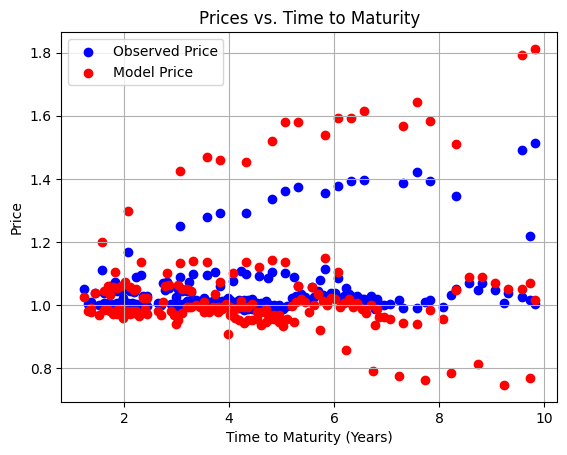

In [133]:
processed_data['model_price'] = processed_data.apply(
    lambda row: theoretical_bond_price(
        row['coupon'], 1, row['tau'], 2, result.x
    ), axis=1
)
plt.scatter(processed_data['tau'], processed_data['midprice'], color='blue', label='Observed Price')
plt.scatter(processed_data['tau'], processed_data['model_price'], color='red', label='Model Price')   
plt.xlabel('Time to Maturity (Years)')
plt.ylabel('Price')
plt.title('Prices vs. Time to Maturity')
plt.legend()
plt.grid(True)
plt.show()

In [134]:
# Define a minimizer for local optimization steps within Basin-Hopping ( will use for first obs each day )
#minimizer_kwargs = {"method": "L-BFGS-B", "args": (bond_data,)}

# Perform the Basin-Hopping global optimization
#result = basinhopping(objective_function, result.x, minimizer_kwargs=minimizer_kwargs, niter=200)

#print(result.x)  # Optimized parameters

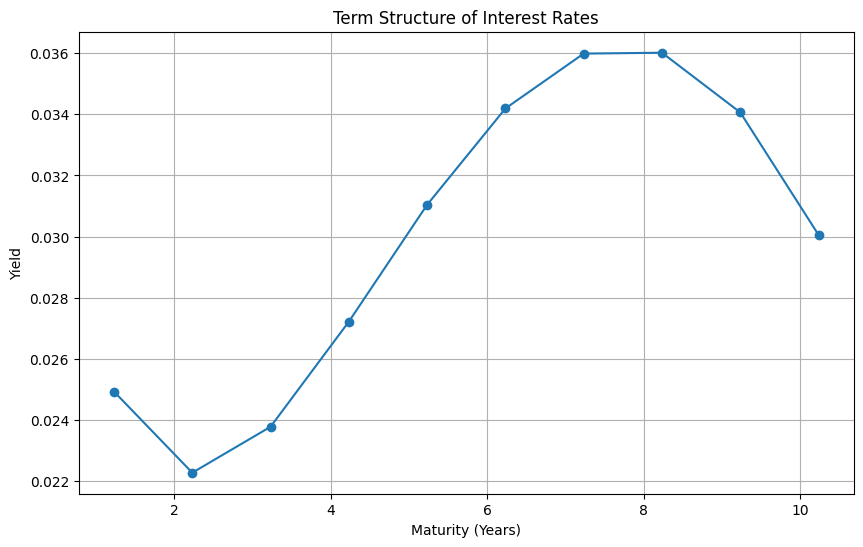

In [135]:
# Assuming 'result.x' contains the optimized parameters [beta0, beta1, beta2, beta3, lambda1, lambda2]
# Replace this with your optimized parameters
optimized_params = result.x

# Assuming 'processed_data' is your DataFrame and it has a column named 'tau'
# Find the minimum value in the 'tau' column
min_tau = processed_data['tau'].min()

# Maturities for 1 to 10 years or starting from min_tau if it is larger
maturities = np.arange(max(1, min_tau), 11)
yields = []

# Calculate yields for each maturity using the optimized parameters
for tau in maturities:
    if tau < min_tau:
        yields.append(np.nan)
    else:
        yields.append(svensson_yield(tau, *optimized_params))

# Plotting the term structure
plt.figure(figsize=(10, 6))
plt.plot(maturities, yields, marker='o')
plt.title("Term Structure of Interest Rates")
plt.xlabel("Maturity (Years)")
plt.ylabel("Yield")
plt.grid(True)
plt.show()

